In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/MyDrive/23Fall_CV_project_data/test/'
model_dir = "/content/drive/MyDrive/23Fall_CV_project_data/1108_FasterRCnn_SaeheeEom/car_plate_od_data/models/"
save_dir = "/content/drive/MyDrive/23Fall_CV_project_data/test_OD_result/"

import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

import os
import random
import numpy as np
import shutil
import os
import numpy as np
import pandas as pd
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from PIL import Image
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import time
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from os import listdir
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2  # 1 class (car plate) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None
num_epochs = 2
model.load_state_dict(torch.load(f'{model_dir}1120_saehee_model_{num_epochs}.pt'))

class CarPlateDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['filename'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['filename'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        # 전부 car plate에 해당하는 사진이기 때문에 다 1로 넣어줍니다
        labels = torch.ones((records.shape[0],), dtype=torch.int64)

        # suppose all instances are not crowd
        # 이미지의 개체 숫자 여러개일 때 1로 설정합니다.
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['filename'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']

            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

images_filenames = listdir(data_dir)
dummy_idxs1 = len(images_filenames) * [0]
dummy_idxs2 = len(images_filenames) * [1]
dummy_df = pd.DataFrame.from_dict({'filename':images_filenames, 'xmin':dummy_idxs1,'xmax':dummy_idxs2,'ymin':dummy_idxs1,'ymax':dummy_idxs2 })

def collate_fn(batch):
    return tuple(zip(*batch))
test_dataset = CarPlateDataset(dummy_df, data_dir.rstrip('/'), get_valid_transform())

test_data_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

images, targets, image_ids = next(iter(test_data_loader))

def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
      idx_list = []

      for idx, score in enumerate(preds[id]['scores']) :
          if idx==0:
              idx_list.append(idx)

      preds[id]['boxes'] = preds[id]['boxes'][idx_list]
      if len(preds[id]['boxes'])==0:
        preds[id]['boxes'] = torch.tensor([[0.0, 0.0, 0.0, 0.0]])
      preds[id]['labels'] = preds[id]['labels'][idx_list]
      preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

# images, targets, image_ids

for im, annot, image_ids in tqdm(test_data_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)
    #annot = [{k: v.to(device) for k, v in t.items()} for t in annot]

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(model, im, 0.5)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)

for i, batch in tqdm(enumerate(annot_all)):
  for j, annot in enumerate(batch):
    filename_idx = int(annot_all[i][j]['filename'][0])
    filename = dummy_df['filename'].unique()[filename_idx]
    image = cv2.imread(f'{data_dir}{filename}', cv2.IMREAD_COLOR)
    pred_box = preds_adj_all[i][j]['boxes'].detach().numpy().astype(np.int32)[0]
    # cv2_imshow(image[pred_box[1]:pred_box[3],pred_box[0]:pred_box[2]])
    cv2.imwrite(save_dir+filename, image[pred_box[1]:pred_box[3],pred_box[0]:pred_box[2]])

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 71.4MB/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker pro

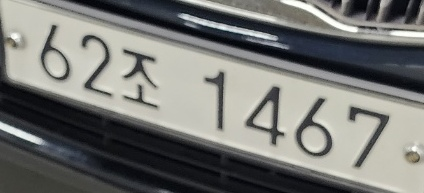

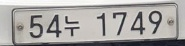

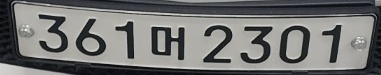

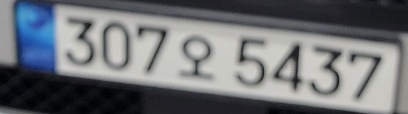

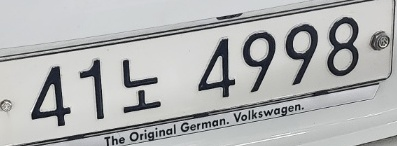

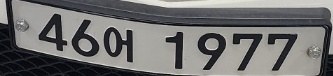

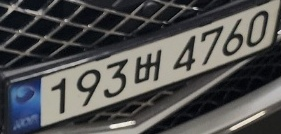

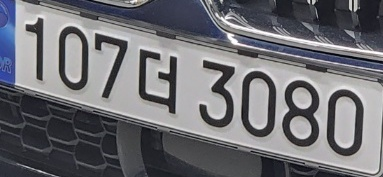

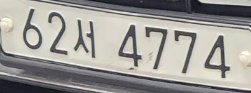

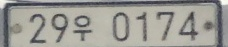

In [ ]:
from os import listdir
from google.colab.patches import cv2_imshow
import cv2
dir = '/content/drive/MyDrive/23Fall_CV_project_data/test_OD_result/'
filenames = listdir(dir)
for i in range(10):
  img=cv2.imread(dir+filenames[i])
  cv2_imshow(img)

In [ ]:
!pip install easyocr
!pip install opencv-python-headless==4.5.4.60
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import copy, math
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import math
import matplotlib
from scipy import ndimage, misc
import random
import argparse
import torchvision.transforms as transforms
from PIL import ImageFont, ImageDraw, Image
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader
from imutils.perspective import four_point_transform
from imutils.contours import sort_contours
import imutils
from easyocr import Reader
import requests
import time
word_list = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'X', '가', '나',
             '다', '라', '마', '거', '너', '더', '러', '머', '버', '서', '어',
             '저', '고', '노', '도', '로', '모', '보', '소', '오', '조', '구',
             '누', '두', '루', '무', '부', '수', '우', '주', '허', '하', '호',
             '배', '공', '해', '육', '합', '국', '아', '자', '바']              # 자동차 번호판에 등장하는 문자들로 이루어진 word list
valid_img_dir = '/content/drive/MyDrive/23Fall_CV_project_data/test_OD_result'
l=os.listdir(valid_img_dir)

train_data_dir = valid_img_dir

train_tensor_list = []
c = 0
d = 0

for filename in os.listdir(train_data_dir):
    c += 1
    if filename in l:
        d += 1
        img_path = os.path.join(train_data_dir, filename)

        img = Image.open(img_path).convert('L')

        transform = transforms.Compose([
            transforms.Resize([128, 512]),
            transforms.ToTensor()
        ])
        tensor = transform(img)

        tensor = torch.clamp(tensor * 255, 0, 255)

        tensor = tensor.round().to(torch.uint8)

        train_tensor_list.append(tensor)

    if c % 1000 == 0:
        print(c, d)

train_all_data = torch.stack(train_tensor_list)
valid_img=train_all_data

import unicodedata
s=[]
for i in range(len(l)):
  l[i]=l[i][:-4]
  l[i]=unicodedata.normalize('NFC',l[i])
  l[i]=list(l[i])
  temp=[]
  for j in range(len(l[i])):
    if l[i][j]!=' ':
      temp.append(word_list.index(str(l[i][j])))
  if len(temp)==7:
    temp.insert(0, 10)
  s.append(temp)
valid_label=torch.tensor(s)
valid_img=np.array(valid_img)
valid_label=np.array(valid_label)
langs = ['ko', 'en']

print("[INFO] OCR'ing input image...")
reader = Reader(lang_list=langs, gpu=True)


def sharpening(image, strength=1.3):      # image sharpening for pre-processing
    # 미분 커널 생성
    kernel = np.array([[-1, -1, -1],
                       [-1,  9, -1],
                       [-1, -1, -1]])

    # 커널을 이미지에 적용하여 선명하게 만듦
    sharpened = cv2.filter2D(image, -1, kernel * strength)

    return sharpened

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 14.2 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.8.1.78
    Uninstalling opencv-python-headless-4.8.1.78:
      Successfully uninstalled opencv-python-headless-4.8.1.78


[INFO] OCR'ing input image...
Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.1% Complete

In [ ]:
# image showing and pre-processing

def plt_show(title='image', img=None, figsize=(8 ,5)):
    #plt.figure(figsize=figsize)

    if type(img) == list:
        if type(title) == list:
            titles = title
        else:
            titles = []

            for i in range(len(img)):
                titles.append(title)

        for i in range(len(img)):
            if len(img[i].shape) <= 2:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
            else:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)

            #plt.subplot(1, len(img), i + 1), plt.imshow(rgbImg)
            #plt.title(titles[i])
            #plt.xticks([]), plt.yticks([])

        #plt.show()
    else:
        if len(img.shape) < 3:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        #plt.imshow(rgbImg)
        #plt.title(title)
        #plt.xticks([]), plt.yticks([])
        #plt.show()

def make_image(image, width, ksize=(5,5), min_threshold=75, max_threshold=200):
  image_list_title = []
  image_list = []

  image = imutils.resize(image, width=width)
  ratio = org_image.shape[1] / float(image.shape[1])

  # 이미지를 grayscale로 변환하고 blur를 적용
  # 모서리를 찾기위한 이미지 연산
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(gray, ksize, 0)
  sharpen = sharpening(np.array(gray))
  edged = cv2.Canny(blurred, min_threshold, max_threshold)

  #image_list_title = ['gray', 'blurred', 'sharpen', 'edged']
  #image_list = [gray, blurred, sharpen, edged]
  image_list_title = ['sharpen']
  image_list = [sharpen]

  # contours를 찾아 크기순으로 정렬
  cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

  findCnt = None

  output = image.copy()

  # 정렬된 contours를 반복문으로 수행하며 4개의 꼭지점을 갖는 도형을 검출
  for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)

    # contours가 크기순으로 정렬되어 있기때문에 제일 첫번째 사각형을 영역으로 판단하고 break
    if len(approx) == 4:
      findCnt = approx
      cv2.drawContours(output, [findCnt], -1, (0, 255, 0), 2)
      break


  # 만약 추출한 윤곽이 없을 경우 오류
  #if findCnt is None:
    #raise Exception(("Could not find outline."))


  #output = image.copy()
  #cv2.drawContours(output, [findCnt], -1, (0, 255, 0), 2)

  #image_list_title.append("Outline")
  #image_list.append(output)

  # 원본 이미지에 찾은 윤곽을 기준으로 이미지를 보정
  if findCnt is None:
    transform_image = org_image
  else:
    transform_image = four_point_transform(org_image, findCnt.reshape(4, 2) * ratio)

  #plt_imshow(image_list_title, image_list)
  #plt_imshow("Transform", transform_image)

  return sharpen

In [ ]:
# 완전 일치 테스트(string match)

count = 0
cnt = 0
output = []

start_time = time.time()

for im in range(0, len(valid_img)):
  image = valid_img[im,0]
  org_image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
  plt_show("orignal image", org_image)
  sharp_image = make_image(org_image, width=200, ksize=(5, 5), min_threshold=20, max_threshold=100)
  sharpen_image = sharpening(image)

  start_point_x = []
  sort_string = []

  results_transform = reader.readtext(sharpen_image, detail = 1)

  for i in range(0, len(results_transform)):
    start_point_x.append(results_transform[i][0][0][0])
  start_point_x = np.array(start_point_x)
  sort_idx = np.argsort(start_point_x)
  results_transform = np.array(results_transform)
  results_transform = results_transform[sort_idx]
  for i in range(0, len(results_transform)):
    sort_string.append(results_transform[i,1])

  results = sort_string

  start_point_x = []
  sort_string = []

  results_transform = reader.readtext(sharp_image, detail = 1)

  for i in range(0, len(results_transform)):
    start_point_x.append(results_transform[i][0][0][0])
  start_point_x = np.array(start_point_x)
  sort_idx = np.argsort(start_point_x)
  results_transform = np.array(results_transform)
  results_transform = results_transform[sort_idx]
  for i in range(0, len(results_transform)):
    sort_string.append(results_transform[i,1])

  results2 = sort_string

  label = []
  for j in results:
    for i in j:
      if i in word_list:
        label.append(i)

  label2 = []
  for j in results2:
    for i in j:
      if i in word_list:
        label2.append(i)

  correct = True
  if len(label) == 7:
    label.insert(0, 10)
    for idx in range(1, 8):
      label[idx] = word_list.index(label[idx])
  elif len(label) == 8:
    for idx in range(0, 8):
      label[idx] = word_list.index(label[idx])
  else :
    correct = False
    for idx in range(0, len(label)):
      label[idx] = word_list.index(label[idx])

  correct2 = True
  if len(label2) == 7:
    label2.insert(0, 10)
    for idx in range(1, 8):
      label2[idx] = word_list.index(label2[idx])
  elif len(label2) == 8:
    for idx in range(0, 8):
      label2[idx] = word_list.index(label2[idx])
  else :
    correct2 = False
    for idx in range(0, len(label2)):
      label2[idx] = word_list.index(label2[idx])

  label = np.array(label, dtype = np.uint8)
  label2 = np.array(label2, dtype = np.uint8)

  if correct:
    correct = bool((np.sum(valid_label[im]==label)==label.shape))

  if correct2:
    correct2 = bool((np.sum(valid_label[im]==label2)==label2.shape))

  if correct:
    count += 1
    label = np.insert(label, 0, 1)
    output.append(label)
  elif correct2:
    count += 1
    label2 = np.insert(label2, 0, 1)
    output.append(label2)
  else:
    label = np.insert(label, 0, 0)
    output.append(label)

  cnt += 1

  if cnt%200 == 0:
    print(cnt, count)

accuracy = count / len(valid_img) * 100

end_time = time.time()

execution_time = end_time - start_time

print(f"accuracy: {accuracy:.2f}%")
print(f"execution time: {execution_time:.2f}s")

import csv

# CSV 파일로 저장
csv_output_path = '/content/drive/MyDrive/23Fall_CV_project_data/data/OCR_output_correct_valid.csv'

# 리스트를 numpy 배열로 변환
output_array = np.array(output)

# numpy 배열을 CSV 파일로 저장
with open(csv_output_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # 각 행을 CSV 파일에 작성
    for row in output_array:
        writer.writerow(row)

<ipython-input-6-847a62c92dda>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  results_transform = np.array(results_transform)
<ipython-input-6-847a62c92dda>:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  results_transform = np.array(results_transform)


accuracy: 81.31%
execution time: 5.12s


<ipython-input-6-847a62c92dda>:127: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  output_array = np.array(output)


In [ ]:
# LCS 기반 글자 단위 일치 테스트(chracter match based on LCS algorithm)

count = 0
cnt = 0
output = []

def LCS(A, B):
  C = np.zeros((len(A) + 1, len(B) + 1))
  D = np.zeros((len(A) + 1, len(B) + 1))

  for i in range(1, len(A) + 1):
    for j in range(1, len(B) + 1):
      if A[i - 1] == B[j - 1]:
        C[i, j] = C[i - 1, j - 1] + 1
        D[i, j] = 1
      elif C[i - 1, j] >= C[i, j - 1]:
        C[i, j] = C[i - 1, j]
        D[i, j] = 2
      else:
        C[i, j] = C[i, j - 1]
        D[i, j] = 4

  lcs = []
  i, j = len(A), len(B)
  while(1):
    if D[i, j] == 1:
      i -= 1
      j -= 1
      lcs.append(A[i - 1])
    elif D[i, j] == 2:
      i -= 1
    elif D[i, j] == 4:
      j -= 1
    else:
      break

  lcs = lcs[::-1]
  lcs = np.array(lcs)

  return C[len(A), len(B)], lcs

start_time = time.time()

for im in range(0, len(valid_img)):
  image = valid_img[im,0]
  org_image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
  plt_show("orignal image", org_image)
  sharp_image = make_image(org_image, width=200, ksize=(5, 5), min_threshold=20, max_threshold=100)
  sharpen_image = sharpening(image)

  start_point_x = []
  sort_string = []

  results_transform = reader.readtext(sharpen_image, detail = 1)

  for i in range(0, len(results_transform)):
    start_point_x.append(results_transform[i][0][0][0])
  start_point_x = np.array(start_point_x)
  sort_idx = np.argsort(start_point_x)
  results_transform = np.array(results_transform)
  results_transform = results_transform[sort_idx]
  for i in range(0, len(results_transform)):
    sort_string.append(results_transform[i,1])

  results = sort_string

  start_point_x = []
  sort_string = []

  results_transform = reader.readtext(sharp_image, detail = 1)

  for i in range(0, len(results_transform)):
    start_point_x.append(results_transform[i][0][0][0])
  start_point_x = np.array(start_point_x)
  sort_idx = np.argsort(start_point_x)
  results_transform = np.array(results_transform)
  results_transform = results_transform[sort_idx]
  for i in range(0, len(results_transform)):
    sort_string.append(results_transform[i,1])

  results2 = sort_string

  label = []
  for j in results:
    for i in j:
      if i in word_list:
        label.append(i)

  label2 = []
  for j in results2:
    for i in j:
      if i in word_list:
        label2.append(i)

  label.insert(0, 10)
  label2.insert(0, 10)

  for idx in range(1, len(label)):
      label[idx] = word_list.index(label[idx])

  for idx in range(1, len(label2)):
      label2[idx] = word_list.index(label2[idx])

  label = np.array(label, dtype = np.uint8)
  label2 = np.array(label2, dtype = np.uint8)

  temp_count, lcs_label = LCS(label, valid_label[im])
  temp_count2, lcs_label2 = LCS(label2, valid_label[im])

  if temp_count >= temp_count2:
    count += temp_count
    output_tensor = torch.Tensor(lcs_label).to(torch.uint8)
  else:
    count += temp_count2
    output_tensor = torch.Tensor(lcs_label2).to(torch.uint8)

  output.append(output_tensor)

  cnt += 1

  if cnt%200 == 0:
    print(cnt, count)

print(cnt, count)

accuracy = count / (8 * len(valid_img)) * 100

max_length = max(tensor.size(0) for tensor in output)

pad_output = [F.pad(tensor, (0, max_length - tensor.size(0)), value=255) for tensor in output]

total_output = torch.stack(pad_output).to(torch.uint8)

end_time = time.time()

execution_time = end_time - start_time

print(f"accuracy: {accuracy:.2f}%")
print(f"execution time: {execution_time:.2f}s")

<ipython-input-7-a4f7af99d348>:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  results_transform = np.array(results_transform)
<ipython-input-7-a4f7af99d348>:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  results_transform = np.array(results_transform)


107 835.0
accuracy: 97.55%
execution time: 5.21s


In [ ]:
output_path = '/content/drive/MyDrive/23Fall_CV_project_data/data/OCR_output_valid.pt'
torch.save(total_output, output_path)
# torch tensor를 csv파일로 저장

import csv

# CSV 파일로 저장
csv_output_path = '/content/drive/MyDrive/23Fall_CV_project_data/data/OCR_output_valid.csv'

# total_output을 CPU로 이동하고 numpy 배열로 변환
output_array = total_output.cpu().numpy()

# numpy 배열을 CSV 파일로 저장
with open(csv_output_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # 각 행을 CSV 파일에 작성
    for row in output_array:
        writer.writerow(row)

def plt_imshow(title='image', img=None, figsize=(8 ,5)):
    plt.figure(figsize=figsize)

    if type(img) == list:
        if type(title) == list:
            titles = title
        else:
            titles = []

            for i in range(len(img)):
                titles.append(title)

        for i in range(len(img)):
            if len(img[i].shape) <= 2:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
            else:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)

            plt.subplot(1, len(img), i + 1), plt.imshow(rgbImg)
            plt.title(titles[i])
            plt.xticks([]), plt.yticks([])

        plt.show()
    else:
        if len(img.shape) < 3:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]), plt.yticks([])
        plt.show()

def sharpen_image(image, strength=1):
    # 미분 커널 생성
    kernel = np.array([[-1, -1, -1],
                       [-1,  9, -1],
                       [-1, -1, -1]])

    # 커널을 이미지에 적용하여 선명하게 만듦
    sharpened = cv2.filter2D(image, -1, kernel * strength)

    return sharpened

def make_scan_image(image, width, ksize=(5,5), min_threshold=75, max_threshold=200):
  image_list_title = []
  image_list = []

  image = imutils.resize(image, width=width)
  ratio = org_image.shape[1] / float(image.shape[1])

  # 이미지를 grayscale로 변환하고 blur를 적용
  # 모서리를 찾기위한 이미지 연산
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(gray, ksize, 0)
  sharpen = sharpen_image(np.array(gray))
  edged = cv2.Canny(blurred, min_threshold, max_threshold)

  image_list_title = ['gray', 'blurred', 'sharpen', 'edged']
  image_list = [gray, blurred, sharpen, edged]

  plt_imshow(image_list_title, image_list)

  return sharpen

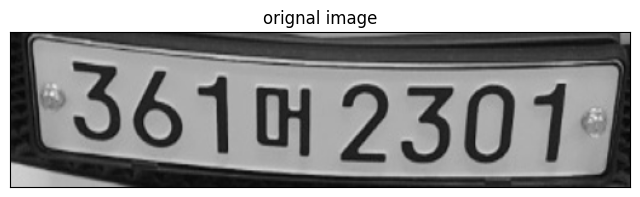

(128, 512, 3)


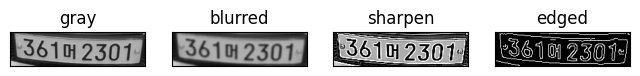

In [ ]:
# 미사용 셀(이미지 확인용)

image = valid_img[2,0]

org_image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
#org_image = cv2.imdecode(org_image, cv2.IMREAD_COLOR)
plt_imshow("orignal image", org_image)
print(org_image.shape)

business_card_image = make_scan_image(org_image, width=200, ksize=(5, 5), min_threshold=20, max_threshold=100)

In [ ]:
# 미사용 셀(확인용)
start_point_x = []
sort_string = []
#results = reader.readtext(image, detail = 0)
results_transform = reader.readtext(business_card_image, detail = 1)  # OCR result - recognized text (word list에 없는 문자 등장 or 문자열 분리되어 인식되기도 함 or 문자열 순서가 바뀌기도 함)
#print(results)
#print(results_transform)

# bounding box의 첫 포인트의 x 좌표를 기준으로 sorting하여 문자열 순서 맞춤(post processing)
for i in range(0, len(results_transform)):
  start_point_x.append(results_transform[i][0][0][0])
start_point_x = np.array(start_point_x)
sort_idx = np.argsort(start_point_x)
results_transform = np.array(results_transform)
results_transform = results_transform[sort_idx]
for i in range(0, len(results_transform)):
  sort_string.append(results_transform[i,1])
print(sort_string)

results = sort_string

# OCR result - recognized text (word list에 없는 문자 등장 or 문자열 분리되어 인식되기도 함)

['[361머2301']


<ipython-input-17-737484b817e5>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  results_transform = np.array(results_transform)


In [ ]:
# 미사용 셀(확인용)

label = []
for j in results:
  for i in j:
    if i in word_list:
      label.append(i)
label

# post processing - 순서에 맞춰서 word list에 있는 문자만 저장
# 이후 추가적인 post processing(test algorithm엔 있음) 통해서 word list index로 변환

['3', '6', '1', '머', '2', '3', '0', '1']

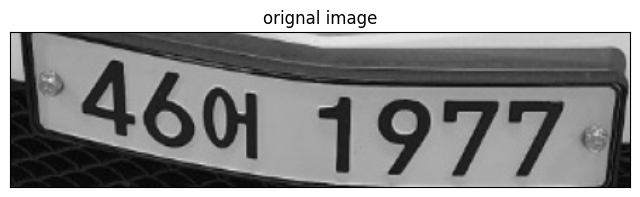

(128, 512, 3)


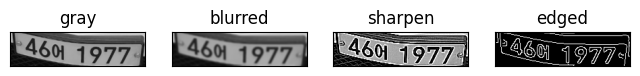

In [ ]:
# 미사용 셀(이미지 확인용)

image = valid_img[5,0] # 2, 5, 9, 56

org_image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
#org_image = cv2.imdecode(org_image, cv2.IMREAD_COLOR)
plt_imshow("orignal image", org_image)
print(org_image.shape)

business_card_image = make_scan_image(org_image, width=200, ksize=(5, 5), min_threshold=20, max_threshold=100)

In [ ]:
# 미사용 셀(확인용)
start_point_x = []
sort_string = []
#results = reader.readtext(image, detail = 0)
results_transform = reader.readtext(business_card_image, detail = 1)
#print(results)
#print(results_transform)

for i in range(0, len(results_transform)):
  start_point_x.append(results_transform[i][0][0][0])
start_point_x = np.array(start_point_x)
sort_idx = np.argsort(start_point_x)
results_transform = np.array(results_transform)
results_transform = results_transform[sort_idx]
for i in range(0, len(results_transform)):
  sort_string.append(results_transform[i,1])
print(sort_string)

results = sort_string

['46어', '1977']


<ipython-input-20-737484b817e5>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  results_transform = np.array(results_transform)


In [ ]:
# 미사용 셀(확인용)

label = []
for j in results:
  for i in j:
    if i in word_list:
      label.append(i)
label

['4', '6', '어', '1', '9', '7', '7']

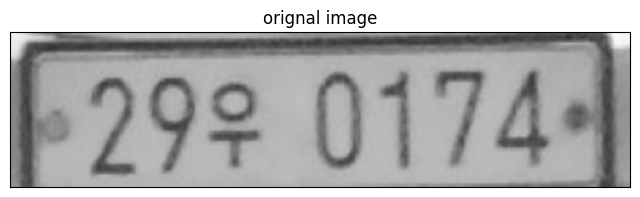

(128, 512, 3)


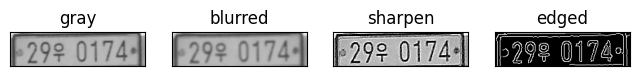

In [ ]:
# 미사용 셀(이미지 확인용)

image = valid_img[9,0] # 2, 5, 9, 56

org_image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
#org_image = cv2.imdecode(org_image, cv2.IMREAD_COLOR)
plt_imshow("orignal image", org_image)
print(org_image.shape)

business_card_image = make_scan_image(org_image, width=200, ksize=(5, 5), min_threshold=20, max_threshold=100)

In [ ]:
# 미사용 셀(확인용)
start_point_x = []
sort_string = []
#results = reader.readtext(image, detail = 0)
results_transform = reader.readtext(business_card_image, detail = 1)
#print(results)
#print(results_transform)

for i in range(0, len(results_transform)):
  start_point_x.append(results_transform[i][0][0][0])
start_point_x = np.array(start_point_x)
sort_idx = np.argsort(start_point_x)
results_transform = np.array(results_transform)
results_transform = results_transform[sort_idx]
for i in range(0, len(results_transform)):
  sort_string.append(results_transform[i,1])
print(sort_string)

results = sort_string

['29우 0174']


<ipython-input-23-737484b817e5>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  results_transform = np.array(results_transform)


In [ ]:
# 미사용 셀(확인용)

label = []
for j in results:
  for i in j:
    if i in word_list:
      label.append(i)
label

['2', '9', '우', '0', '1', '7', '4']

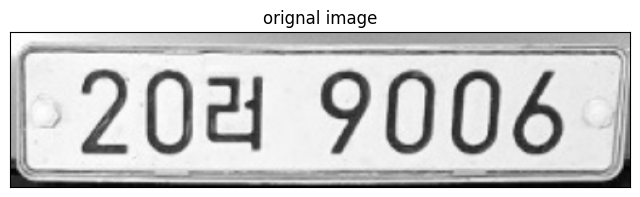

(128, 512, 3)


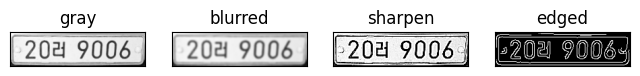

In [ ]:
# 미사용 셀(이미지 확인용)

image = valid_img[56,0] # 2, 5, 9, 56

org_image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
#org_image = cv2.imdecode(org_image, cv2.IMREAD_COLOR)
plt_imshow("orignal image", org_image)
print(org_image.shape)

business_card_image = make_scan_image(org_image, width=200, ksize=(5, 5), min_threshold=20, max_threshold=100)

In [ ]:
# 미사용 셀(확인용)
start_point_x = []
sort_string = []
#results = reader.readtext(image, detail = 0)
results_transform = reader.readtext(business_card_image, detail = 1)
#print(results)
#print(results_transform)

for i in range(0, len(results_transform)):
  start_point_x.append(results_transform[i][0][0][0])
start_point_x = np.array(start_point_x)
sort_idx = np.argsort(start_point_x)
results_transform = np.array(results_transform)
results_transform = results_transform[sort_idx]
for i in range(0, len(results_transform)):
  sort_string.append(results_transform[i,1])
print(sort_string)

results = sort_string

# '러'가 '려'로 인식되었다

['20려 9006']


<ipython-input-26-737484b817e5>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  results_transform = np.array(results_transform)


In [ ]:
# 미사용 셀(확인용)

label = []
for j in results:
  for i in j:
    if i in word_list:
      label.append(i)
label

# word_list에 없는 '려'가 제외되었다

['2', '0', '9', '0', '0', '6']